In [1]:
# Install Kaggle library
!pip install -q kaggle

# Make a directory for Kaggle and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d mdkhurshidjahan01/figshare-brain-tumor-dataset

# Unzip the downloaded dataset
!unzip figshare-brain-tumor-dataset.zip -d brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/mdkhurshidjahan01/figshare-brain-tumor-dataset
License(s): Apache 2.0
100% 436M/436M [00:14<00:00, 35.6MB/s]
100% 436M/436M [00:14<00:00, 31.4MB/s]
Archive:  figshare-brain-tumor-dataset.zip
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_103192.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_104263.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_105758.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_106611.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_107584.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_111735.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_114652.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_115499.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_121515.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_135912.

Found 2449 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1

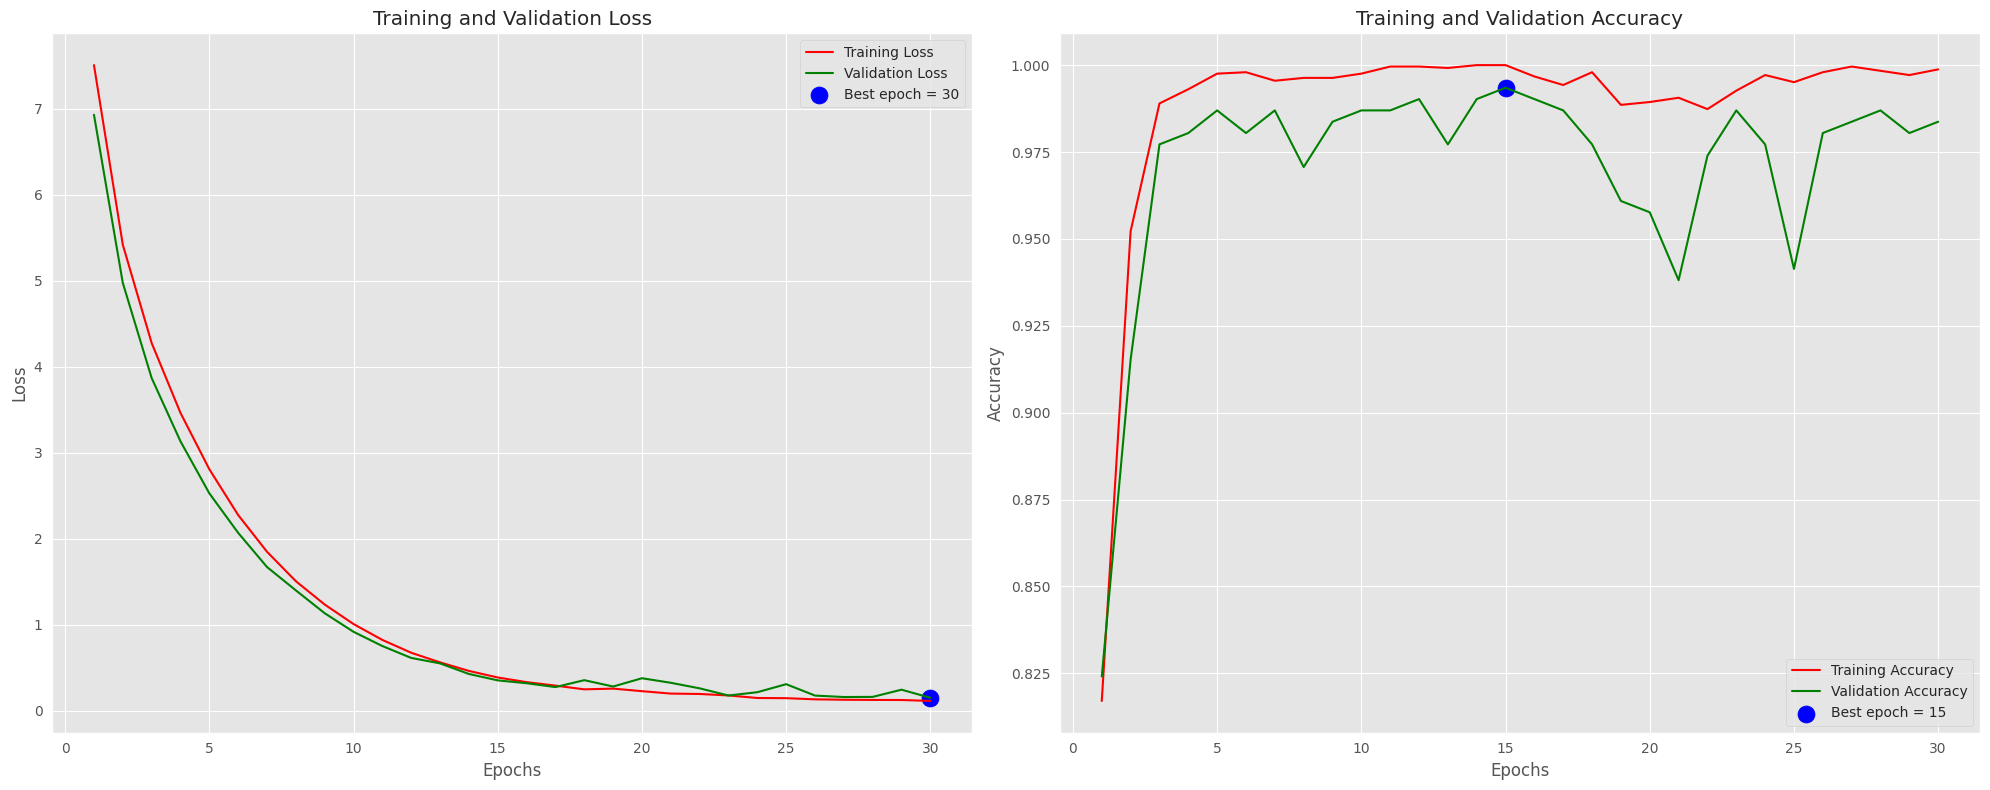

10/16 [=================>............] - ETA: 1s - loss: 0.1487 - accuracy: 0.9837

10/16 [=================>............] - ETA: 1s - loss: 0.1983 - accuracy: 0.9674

16/16 [==============================] - 3s 183ms/step - loss: 0.1983 - accuracy: 0.9674
Train Loss:  0.1019674688577652
Train Accuracy:  0.998046875
--------------------
Validation Loss:  0.14870434999465942
Validation Accuracy:  0.9837133288383484
--------------------
Test Loss:  0.19830669462680817
Test Accuracy:  0.9674267172813416
10/10 [==============================] - 5s 269ms/step


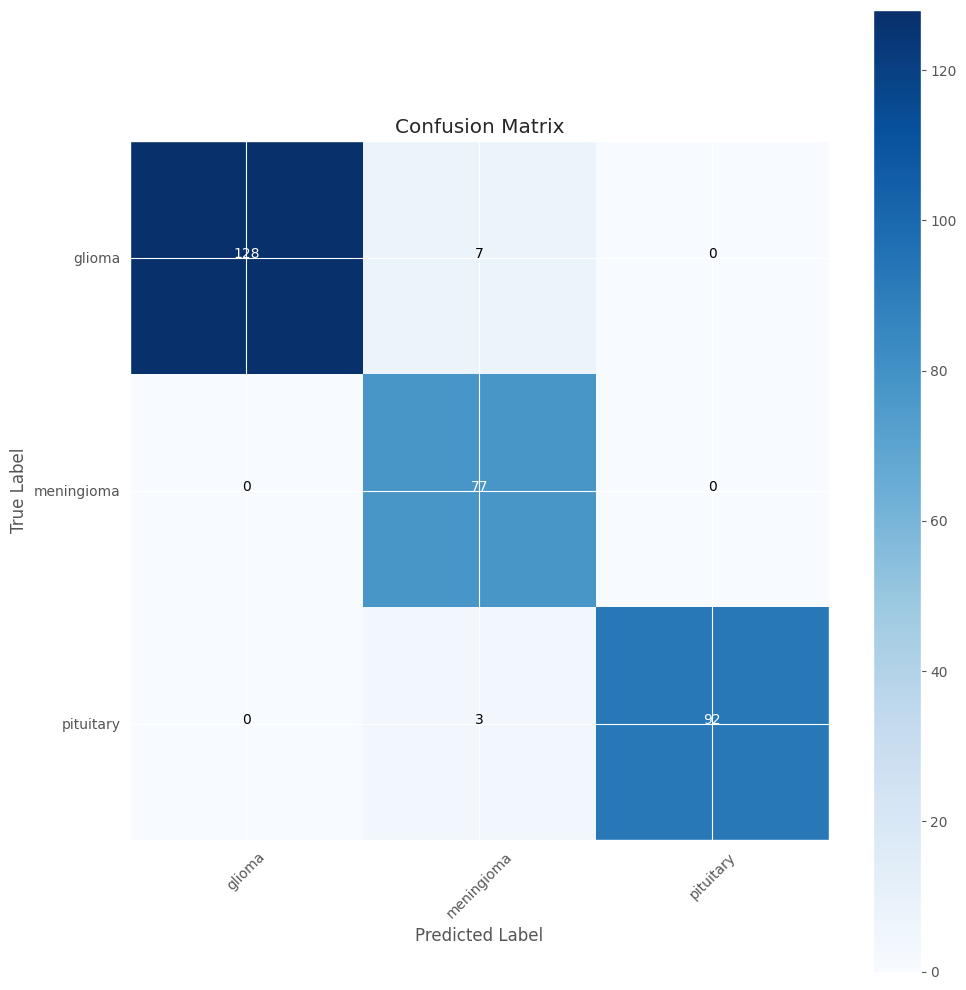

              precision    recall  f1-score   support

      glioma       1.00      0.95      0.97       135
  meningioma       0.89      1.00      0.94        77
   pituitary       1.00      0.97      0.98        95

    accuracy                           0.97       307
   macro avg       0.96      0.97      0.97       307
weighted avg       0.97      0.97      0.97       307



In [2]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

# Paths to your training and testing data
train_data_path = '/content/brain_tumor_dataset/Fig Share/Training'
test_data_path = '/content/brain_tumor_dataset/Fig Share/Testing'

# Create dataframes for training and testing data
def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        filelists = os.listdir(f_path)
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    return pd.concat([Fseries, Lseries], axis=1)

train_df = create_dataframe(train_data_path)
test_df = create_dataframe(test_data_path)

# Split test data into validation and test sets
valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

img_size = (150, 150)
batch_size = 32

# ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

img_shape = (img_size[0], img_size[1], 3)
classes = train_gen.class_indices
num_class = len(classes)

base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback()])

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Training history
plt.figure(figsize=(20, 8))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

train_score = model.evaluate(train_gen, steps=16, verbose=1)
valid_score = model.evaluate(valid_gen, steps=16, verbose=1)
test_score = model.evaluate(test_gen, steps=16, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=classes))


In [ ]:
inceptionresnetv2

Found 2449 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
219055592/219055592 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 batch_normalization_298 (B  (None, 1536)              6144      
 atchNormalization)                                              
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
    

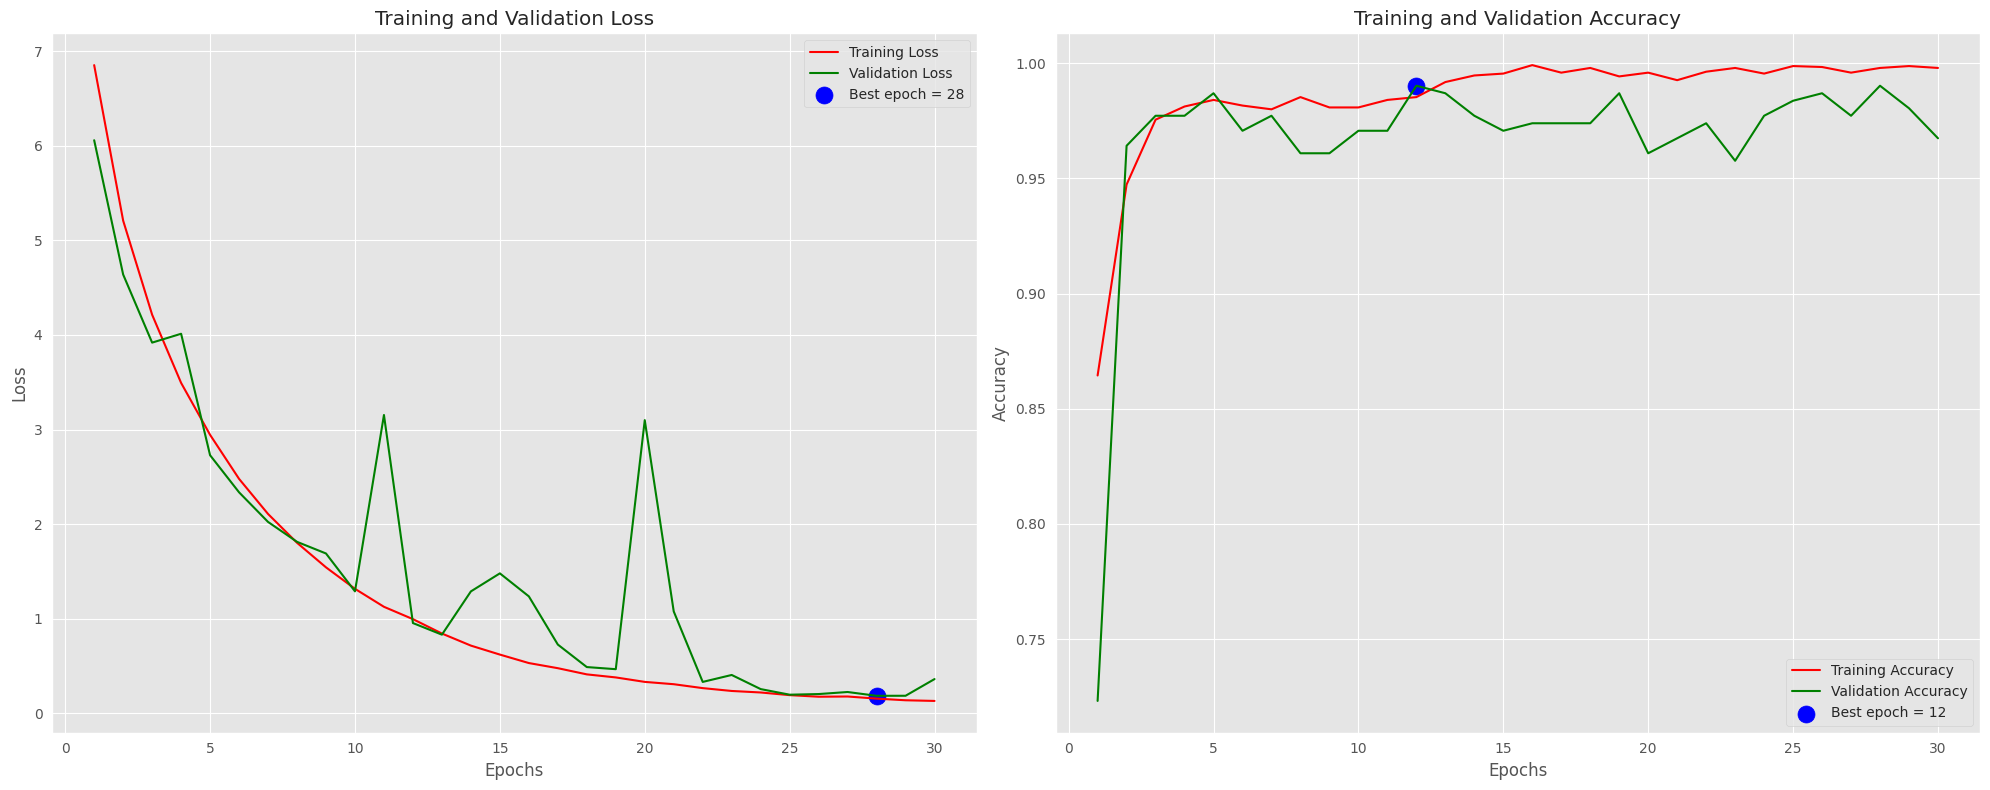

10/16 [=================>............] - ETA: 1s - loss: 0.3635 - accuracy: 0.9674

10/16 [=================>............] - ETA: 1s - loss: 0.2168 - accuracy: 0.9837

16/16 [==============================] - 3s 187ms/step - loss: 0.2168 - accuracy: 0.9837
Train Loss:  0.15529243648052216
Train Accuracy:  0.998046875
--------------------
Validation Loss:  0.36346662044525146
Validation Accuracy:  0.9674267172813416
--------------------
Test Loss:  0.2167501002550125
Test Accuracy:  0.9837133288383484
10/10 [==============================] - 7s 292ms/step


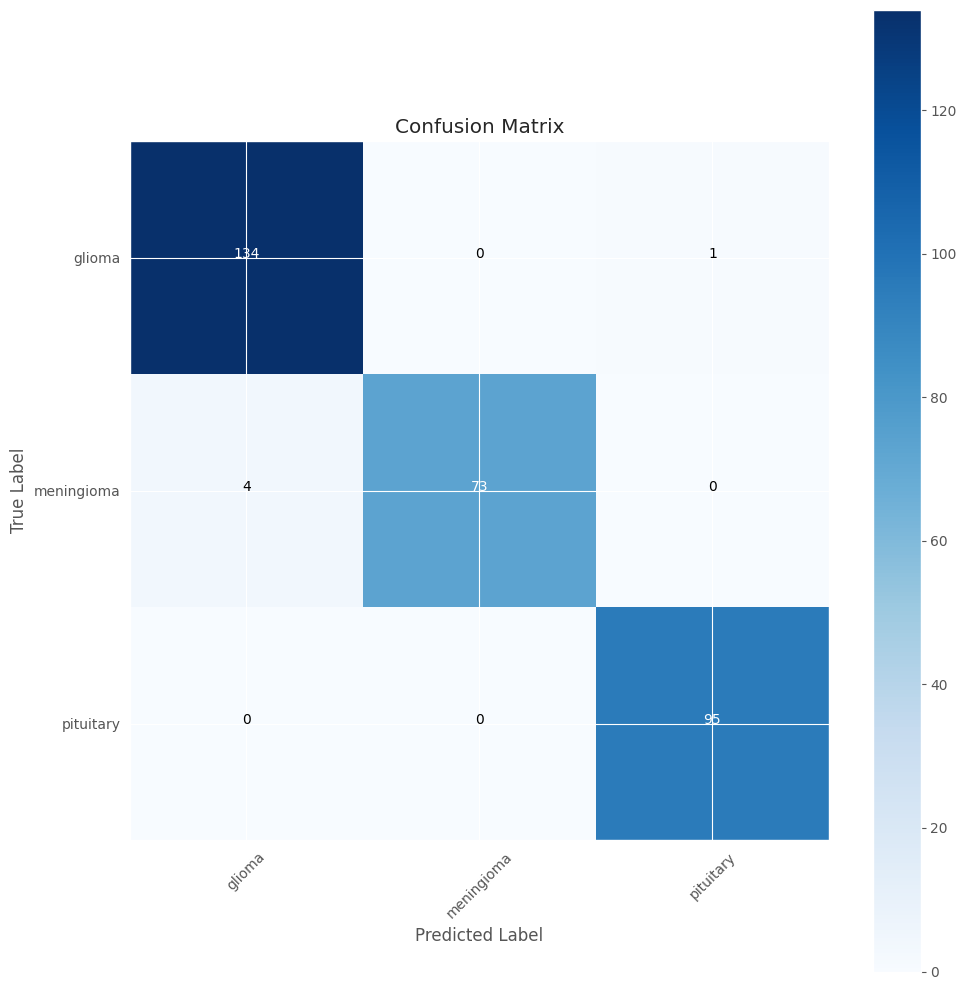

              precision    recall  f1-score   support

      glioma       0.97      0.99      0.98       135
  meningioma       1.00      0.95      0.97        77
   pituitary       0.99      1.00      0.99        95

    accuracy                           0.98       307
   macro avg       0.99      0.98      0.98       307
weighted avg       0.98      0.98      0.98       307



In [3]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import regularizers

sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

# Paths to your training and testing data
train_data_path = '/content/brain_tumor_dataset/Fig Share/Training'
test_data_path = '/content/brain_tumor_dataset/Fig Share/Testing'

# Function to create dataframes for training and testing data
def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        filelists = os.listdir(f_path)
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    return pd.concat([Fseries, Lseries], axis=1)

train_df = create_dataframe(train_data_path)
test_df = create_dataframe(test_data_path)

# Split test data into validation and test sets
valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

img_size = (150, 150)
batch_size = 32

# ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

img_shape = (img_size[0], img_size[1], 3)
classes = train_gen.class_indices
num_class = len(classes)

base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback()])

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Training history plot
plt.figure(figsize=(20, 8))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation on train, validation, and test sets
train_score = model.evaluate(train_gen, steps=16, verbose=1)
valid_score = model.evaluate(valid_gen, steps=16, verbose=1)
test_score = model.evaluate(test_gen, steps=16, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Confusion Matrix and Classification Report
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=classes))